# Simple Sentence Similarity (from github) - with application of the methods to a sample dataset at the end

### Required libraries

Libraries ```seaborn```, ```tensorflow``` and ```tensorflow_hub``` are not included in the basic setup of the environment (requirements.txt) because of their size. At first you may need to install them. If you encounter "module not found" error, uncomment the lines below and run the cell in order to install them in the environment.

In [ ]:
# !pip3 intall seaborn
# !pip3 install tensorflow
# !pip3 install tensorflow_hub

## Data

### STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark


In [21]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

In [22]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


In [24]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

### SICK data

The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [3]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)

In [4]:
sick_all[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


### InferSent

[InferSent](https://github.com/facebookresearch/InferSent) is a pre-trained encoder that produces sentence embeddings. 
More particularly, it is a BiLSTM with max pooling that was trained on the SNLI dataset, 570k English sentence pairs labelled with one of three categories: entailment, contradiction or neutral. InferSent was developed and trained by Facebook Research.

Let's first download the resources we need.

In [ ]:
  
# !wget -nc https://raw.githubusercontent.com/facebookresearch/InferSent/master/models.py
# !wget -nc https://s3.amazonaws.com/senteval/infersent/infersent.allnli.pickle

At the first time you need to download the infersent1.pkl model. Uncomment and run the cell below

In [6]:
# !mkdir encoder
# !curl -Lo encoder/infersent1.pkl https://s3.amazonaws.com/senteval/infersent/infersent1.pkl

mkdir: encoder: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  4366k      0  0:00:34  0:00:34 --:--:-- 6723k 0  3924k      0  0:00:38  0:00:28  0:00:10 5681k


Infersent uses glove model. You can download it by uncommenting and running the cell below

In [ ]:
# !curl -Lo models/ https://nlp.stanford.edu/data/glove.840B.300d.zip
# !cd models && unzip glove.840B.300d.zip

In [8]:

PATH_TO_GLOVE = os.path.expanduser("models/glove.840B.300d.txt")


Then we load the model.

In [9]:

import torch
from models import InferSent
V = 1
MODEL_PATH = 'models/infersent1.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
infersent.set_w2v_path(PATH_TO_GLOVE)

In [10]:
# import torch
# # infersent = torch.load('infersent.allnli.pickle')

# infersent = torch.load('infersent.allnli.pickle', map_location=lambda storage, loc: storage)
# infersent.use_cuda = False
# infersent.set_glove_path(PATH_TO_GLOVE)

Finally, we can run the benchmark by having InferSent encode the two sets of sentences and compute the cosine similarity between the corresponding sentences.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def run_inf_benchmark(sentences1, sentences2):
    
    raw_sentences1 = [sent1.raw for sent1 in sentences1]
    raw_sentences2 = [sent2.raw for sent2 in sentences2]
    
    infersent.build_vocab(raw_sentences1 + raw_sentences2, tokenize=True)
    embeddings1 = infersent.encode(raw_sentences1, tokenize=True)
    embeddings2 = infersent.encode(raw_sentences2, tokenize=True)
    
    inf_sims = []
    for (emb1, emb2) in zip(embeddings1, embeddings2): 
        sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
        inf_sims.append(sim)

    return inf_sims   

### Google Sentence Encoder

The [Google Sentence Encoder](https://www.tensorflow.org/hub/modules/google/universal-sentence-encoder/1) is Google's answer to Facebook's InferSent. It comes in two forms: 

- a Transformer model that takes the element-wise sum of the context-aware word representations produced by the encoding subgraph of a Transformer model.
- a Deep Averaging Network (DAN) where input embeddings for words and bigrams are averaged together and passed through a feed-forward deep neural network.

The Transformer model tends to give better results, but at the time of writing, only the DAN-based encoder was available.

In contrast to InferSent, the Google Sentence Encoder was trained on a combination of unsupervised data (in a skip-thought-like task) and supervised data (the SNLI corpus).

The Google Sentence Encoder can be loaded from the Tensorflow Hub.

In [15]:
import tensorflow_hub as hub

#in case ssl errors appear
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

Like InferSent above, we'll have the it encode the two sets of sentences and return the similarities between the embeddings it produced.

In [16]:
def run_gse_benchmark(sentences1, sentences2):
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
    sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
        
    sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [gse_sims] = session.run(
            [sim_scores],
            feed_dict={
                sts_input1: [sent1.raw for sent1 in sentences1],
                sts_input2: [sent2.raw for sent2 in sentences2]
            })
    return gse_sims


## Experiments

Finally, it's time to run the actual experiments. 

In [17]:
def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors

In [ ]:
import functools as ft

benchmarks = [
              ("GSE", run_gse_benchmark),
              ("INF", run_inf_benchmark)
             ]

global PYEMD_EXT
pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)
pearson_results["SICK-TEST"], spearman_results["SICK-TEST"] = run_experiment(sick_test, benchmarks)
pearson_results["STS-DEV"], spearman_results["STS-DEV"] = run_experiment(sts_dev, benchmarks)
pearson_results["STS-TEST"], spearman_results["STS-TEST"] = run_experiment(sts_test, benchmarks)  


GSE 0.7282557455668891


### For external imports

In [27]:

class similarity_benchmarks:
    """untested, intended usage: 
    from SentenceSimilarityWithGloveINfersentGoogle import similarity_benchmarks"""
    benchmarks_sim = benchmarks

## Results

Let's take a look at our results. We'll mostly work with Pearson correlation, as is standard in the literature, except where Spearman correlation sheds additional light on our findings.

In [23]:
plt.rcParams['figure.figsize'] = (10,5)

pearson_results_df = pd.DataFrame(pearson_results)
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})

spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df = spearman_results_df.transpose()
spearman_results_df = spearman_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})



### Baselines

- Simple word2vec embeddings outperform GloVe embeddings.
- With word2vec, it's unclear whether using a stoplist or tf-idf weighting helps. With STS it sometimes does; with SICK it does not. Simply computing an unweighted average of all word2vec embeddings consistently performs pretty well.
- With GloVe, using a stoplist looks like a very good idea. Using tf-idf weights does not help, with or without a stoplist.

### Pretrained encoders

Pre-trained encoders have a lot to be said for them. However, our results indicate they are not yet able to capitalize fully on their training regime. Throughout our tests, Google's Sentence Encoder looks like a better choice than InferSent. However, the Pearson correlation coefficient shows very little difference with Smooth Inverse Frequency. The differences in Spearman correlation are more outspoken. This may indicate that the Google Sentence Encoder more often gets the relative ordering of the sentences right, but not necessarily the relative differences between them.

In [ ]:
pearson_results_df[[ "INF", "GSE"]].plot(kind="bar").legend(loc="lower left")
spearman_results_df[[ "INF", "GSE"]].plot(kind="bar").legend(loc="lower left")

## Conclusions

These are the most important conclusions:

- When you're computing sentence similarity, word2vec embeddings are a safer choice than GloVe embeddings.
- Although an unweighted average of the word embeddings in the sentence holds its own as a simple baseline, Smooth Inverse Frequency is usually a stronger alternative.
- When you can use a pre-trained encoder, pick Google's Sentence Encoder, but remember its performance gain may not be all that spectacular.

### Putting it all together

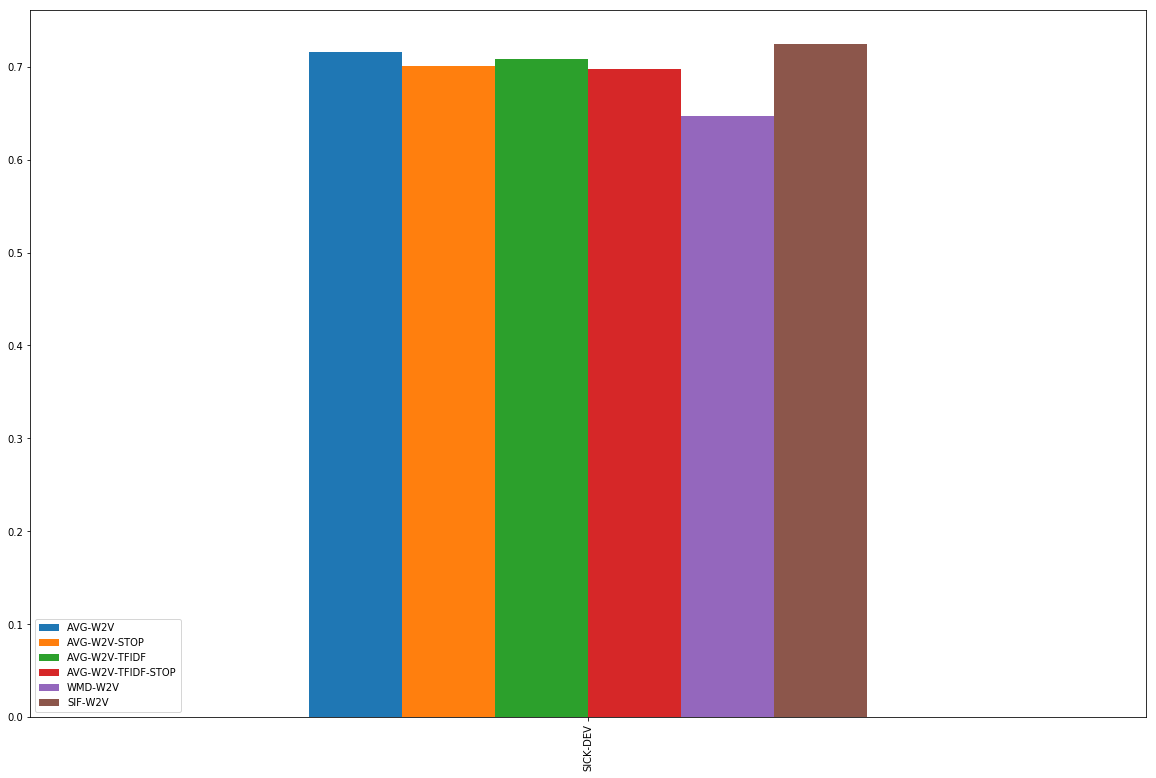

In [52]:
plt.rcParams['figure.figsize'] = (20,13)
pearson_results_df.plot(kind="bar").legend(loc="lower left")